In [1]:
import csv
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

nexus_csv = "../data/1107/swing_1/pose_coord.csv"


#### **Parse Nexus csv file & make NPZ file**


**Function: Parse nexus csf file**


In [2]:
def parse(filename):
    fps, labels, keypoints = 0, [], []

    fir_df = pd.read_csv(filename, nrows=1)
    fps = int(fir_df.values[0][0])

    df = pd.read_csv(filename, skiprows=[0, 1], usecols=range(86)) # number of columns
    pattern = re.compile(r"golf:(\w+)") # labels pattern
    for col in df.columns.values:
        matchs = pattern.match(col)
        if matchs: labels.append(matchs[1])
    
    data = df.iloc[2:, 2:]
    data.fillna(value=0, inplace=True)
    data = data.values
    for i in range(len(data)):
        frame_coord = []
        for j in range(0, len(data[i]), 3):
            frame_coord.append([float(data[i][j]), -float(data[i][j+1]), float(data[i][j+2])])
        
        keypoints.append(frame_coord)
    
    result = {"fps": fps, "labels": labels, "keypoints": keypoints}
    
    return result
result = parse(nexus_csv)


**Save NPZ file**


In [3]:
result = parse(nexus_csv)
np.savez(
    "nexus.npz",
    fps=result["fps"],
    labels=result["labels"],
    keypoints=result["keypoints"],
)


#### **Test**


In [4]:
nexus = np.load("nexus.npz", allow_pickle=True)
print(nexus.files)
print(nexus["labels"])

fps = nexus["fps"]
frame_total = len(nexus["keypoints"])


['fps', 'labels', 'keypoints']
['head1' 'head2' 'right_arm1' 'right_arm2' 'right_arm3' 'right_arm4'
 'right_arm5' 'right_arm6' 'left_arm1' 'left_arm2' 'left_arm3' 'left_arm4'
 'left_arm5' 'left_arm6' 'center1' 'center2' 'center3' 'center4' 'center5'
 'center6' 'right_leg1' 'right_leg2' 'right_leg3' 'left_leg1' 'left_leg2'
 'left_leg3' 'club1' 'club2']


**nycu golf label**


In [5]:
label_vicon = nexus["labels"].tolist()
label_person = {
    0: "hip",  # estimate
    1: "r_hip", 
    2: "r_knee", 
    3: "r_ankle", 
    4: "l_hip", 
    5: "l_knee", 
    6: "l_ankle", 
    7: "spine", 
    8: "neck", # estimate
    9: "chin", # estimate
    10: "head", 
    11: "l_shoulder", 
    12: "l_elbow", 
    13: "l_wrist", 
    14: "r_shoulder", 
    15: "r_elbow", 
    16: "r_wrist"}
label_club = {0: "shaft", 1: "head"}

edges_person = [(0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6), (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16)]
edges_club = [(0, 1)]


**Find nexus csv data index by label name from nycu custom index**


In [6]:
def get_key(label_name):
    for key, value in enumerate(nexus["labels"]):
        if value == label_name:
            return key
    return -1


In [7]:
kps_person = []
kps_club = []

for item in nexus["keypoints"]:

    # person 
    head = (item[label_vicon.index("head1")] + item[label_vicon.index("head2")]) / 2

    spine = (item[label_vicon.index("center1")] + item[label_vicon.index("center2")]) / 2
    r_hip = (item[label_vicon.index("center3")] + item[label_vicon.index("center4")]) / 2
    l_hip = (item[label_vicon.index("center5")] + item[label_vicon.index("center6")]) / 2
    hip = (r_hip + l_hip) / 2

    l_shoulder = (item[label_vicon.index("left_arm1")] + item[label_vicon.index("left_arm2")]) / 2
    r_shoulder = (item[label_vicon.index("right_arm1")] + item[label_vicon.index("right_arm2")]) / 2
    neck = (l_shoulder + r_shoulder) / 2

    chin = (head + neck) / 2

    l_elbow = (item[label_vicon.index("left_arm3")] + item[label_vicon.index("left_arm4")]) / 2
    r_elbow = (item[label_vicon.index("right_arm3")] + item[label_vicon.index("right_arm4")]) / 2

    l_wrist = (item[label_vicon.index("left_arm5")] + item[label_vicon.index("left_arm6")]) / 2
    r_wrist = (item[label_vicon.index("right_arm5")] + item[label_vicon.index("right_arm6")]) / 2

    l_knee = (item[label_vicon.index("left_leg1")] + item[label_vicon.index("left_leg2")]) / 2
    r_knee = (item[label_vicon.index("right_leg1")] + item[label_vicon.index("right_leg2")]) / 2

    l_ankle = item[label_vicon.index("left_leg3")]
    r_ankle = item[label_vicon.index("right_leg3")]

    kps_person.append([
        hip.tolist(), r_hip.tolist(), r_knee.tolist(), r_ankle.tolist(), l_hip.tolist(), 
        l_knee.tolist(), l_ankle.tolist(), spine.tolist(), neck.tolist(), chin.tolist(), 
        head.tolist(), l_shoulder.tolist(), l_elbow.tolist(), l_wrist.tolist(), r_shoulder.tolist(), 
        r_elbow.tolist(), r_wrist.tolist()
    ])

    # club
    shaft = (item[label_vicon.index("club1")]).tolist()
    club_head = (item[label_vicon.index("club2")]).tolist()
    kps_club.append([shaft, club_head])

kps_person = np.array(kps_person)
print("kps_person:", kps_person.shape)

kps_club = np.array(kps_club)
print("kps_club:", kps_club.shape)


kps_person: (405, 17, 3)
kps_club: (405, 2, 3)


**Cut off useless data**


In [8]:
frame_total = kps_person.shape[0]

print(kps_person.shape)
print(frame_total)


(405, 17, 3)
405


**Plot 3D & save to mp4 file**

In [9]:
def update_video(num):
    ax.clear()
    fig.suptitle(f"Frame: {num+1} / {frame_total}")

    # person
    kps = kps_person[num]
    xs, ys, zs = kps[:, 0], kps[:, 1], kps[:, 2]
    for item in edges_person:
        ax.plot([xs[item[0]], xs[item[1]]], [ys[item[0]], ys[item[1]]], [zs[item[0]], zs[item[1]]], linestyle="solid", linewidth="2", color="green")
    for value in range(17):
        ax.scatter(xs[value], ys[value], zs[value], s=12, c="green", marker="o")

    # club
    kps = kps_club[num]
    xs, ys, zs = kps[:, 0], kps[:, 1], kps[:, 2]
    for item in edges_club:
        ax.plot([xs[item[0]], xs[item[1]]], [ys[item[0]], ys[item[1]]], [zs[item[0]], zs[item[1]]], linestyle="solid", linewidth="2", color="red")
    for value in range(2):
        ax.scatter(xs[value], ys[value], zs[value], s=12, c="red", marker="o")

    ax.scatter(0, 0, 0, s=36, c="blue", marker="o")

    ax.view_init(elev=10, azim=200)
    ax.set_xlim(0, 1800)
    ax.set_ylim(600, -1200)
    ax.set_zlim(0, 1800)

    # ax.set_xticklabels([0, 900, 1800])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])


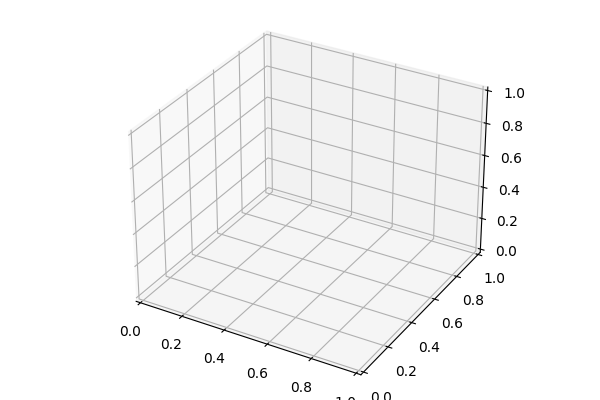

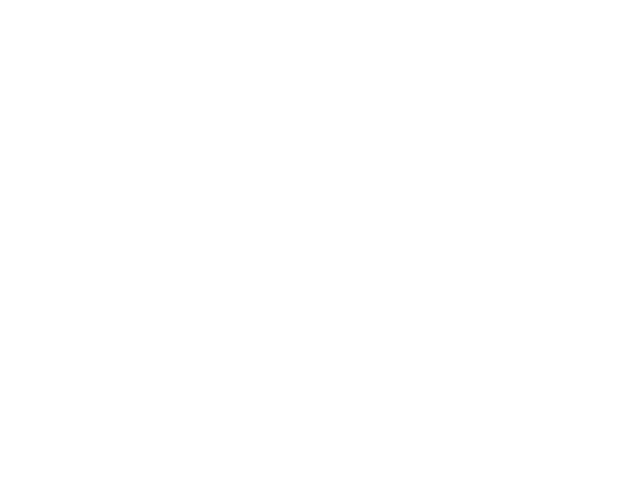

In [11]:
%matplotlib widget
from matplotlib import gridspec

plt.clf()

fig = plt.figure(figsize=(6, 4))
fig.tight_layout()
fig.subplots_adjust(left=0.02, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax = fig.add_subplot(projection="3d")

ani = animation.FuncAnimation(fig, update_video, frames=np.arange(0, frame_total), interval=1000/fps, repeat=False)
plt.show()
ani.save("output.mp4", writer="ffmpeg", fps=fps, dpi=150)
